In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import seaborn as sns
import glob
import warnings

warnings.filterwarnings('ignore')

sns.set(rc={"figure.dpi":1200})
sns.set_context('notebook')
sns.set_style("ticks")

mpl.style.use('default')

# Update rcParams for global consistency
mpl.rcParams.update({
    'axes.linewidth': 7,           # Line width for axes
    'xtick.major.size': 20,        # Major tick size
    'xtick.major.width': 7,        # Major tick width
    'xtick.minor.size': 10,        # Minor tick size
    'xtick.minor.width': 7,        # Minor tick width
    'ytick.major.size': 20,        # Major tick size
    'ytick.major.width': 7,        # Major tick width
    'ytick.minor.size': 10,        # Minor tick size
    'ytick.minor.width': 7,        # Minor tick width
    'ytick.labelsize': 60,         # Label size for y ticks
    'xtick.labelsize': 60,         # Label size for x ticks
    'font.size': 60,               # Font size for text
    'font.sans-serif': 'Arial',
    'mathtext.fontset': 'custom',
    'mathtext.rm': 'Arial',
    'mathtext.it': 'Arial',
    'mathtext.bf': 'Arial:bold',
    'lines.linewidth': 7,          # Line width for all lines
    'scatter.marker': 'o',         # Default marker for scatter
    'lines.markersize': 10,        # Marker size for scatter in points
    'axes.titlesize': 'large',     # Title size
    'axes.labelsize': 'large',     # Label size for axes
    'legend.fontsize': 'large'     # Font size for legends
})


In [18]:
###IMPORT DATAFRAMES AND FILTER MAIN LIVE-CELL DATAFRAME
df = pd.read_csv('STALLER_MANUSCRIPT_HIF1A_CITED2_MASTER.csv',index_col=0)
df = df[(df['area']<10000)]
df = df[(df['log directA']>3.1)]
df = df[(df['log directA']<3.9)]
###KEEP ONLY CONSTRUCTS WITH more than 30 cells per well 
# Group by 'ID' and get 'well' value counts for each group
grouped_well_counts = df.groupby('ID')['well'].value_counts()

# Convert the Series to a DataFrame for easier filtering
grouped_well_counts = grouped_well_counts.reset_index(name='count')

# Identify 'ID' and 'well' pairs with a count of 30 or more
valid_wells = grouped_well_counts[grouped_well_counts['count'] >= 30]

# Merge the valid_wells DataFrame back with the original df to filter it
# Only keep rows from df that have 'ID' and 'well' combinations appearing in valid_wells
df_filtered = df.merge(valid_wells[['ID', 'well']], on=['ID', 'well'])

# The df_filtered now contains only the rows from the original df where the 'well' count per 'ID' is 30 or more
df=df_filtered
sim=pd.read_csv('sim.csv',index_col=0)
#select for HIF and CITED2
HIF = df[df['protein'] != 'CITED2']
CITED2 = df[df['protein'] != 'HIF1A']
sim_HIF = sim[sim['protein'] != 'CITED2']
sim_CITED2 = sim[sim['protein'] != 'HIF1a']

In [19]:
##NORMALIZE Ree from PREDICTION HIF1A

# Identify the WT row
WT_row = sim_HIF[sim_HIF['mut name'] == 'WT']

# Ensure there is exactly one WT row
if len(WT_row) == 1:
    WT_avg_median = WT_row['Ree'].values[0]
  
    # Normalize 'avg_median' and calculate propagated error
    sim_HIF['normalized_Ree'] = sim_HIF['Ree'] / WT_avg_median
    
##NORMALIZE Ree from PREDICTION CITED2
# Identify the WT row
WT_row = sim_CITED2[sim_CITED2['mut name'] == 'WT']

# Ensure there is exactly one WT row
if len(WT_row) == 1:
    WT_avg_median = WT_row['Ree'].values[0]
  
    # Normalize 'avg_median' and calculate propagated error
    sim_CITED2['normalized_Ree'] = sim_CITED2['Ree'] / WT_avg_median

In [20]:
###GET AVERAGE MEDIAN AND STD DEV OF MEDIAN, ALONG WITH NORMALIZED MEDIAN AND ERROR PROPAGATION###
# Step 1: Group by 'well' and 'mut name', then calculate the median for each group
medians_by_well = HIF.groupby(['well', 'mut name'])['Ef'].median().reset_index(name='median_Ef')

# Step 2: Calculate the average and standard deviation of these medians for each 'mut name'
HIF_stats = medians_by_well.groupby('mut name')['median_Ef'].agg(
    avg_median='mean',
    std_dev_median='std'
).reset_index()

# Identify the WT row
WT_row = HIF_stats[HIF_stats['mut name'] == 'WT']

# Ensure there is exactly one WT row
if len(WT_row) == 1:
    WT_avg_median = WT_row['avg_median'].values[0]
    WT_std_dev_median = WT_row['std_dev_median'].values[0]
    
    # Normalize 'avg_median' and calculate propagated error
    HIF_stats['normalized_avg_median'] = HIF_stats['avg_median'] / WT_avg_median
    HIF_stats['propagated_error'] = abs(HIF_stats['normalized_avg_median']) * (
        (HIF_stats['std_dev_median'] / HIF_stats['avg_median'])**2 +
        (WT_std_dev_median / WT_avg_median)**2
    )**0.5
else:
    print("Error: There should be exactly one 'WT' entry.")

# Display the updated DataFrame
print(HIF_stats)

###GET AVERAGE MEDIAN AND STD DEV OF MEDIAN, ALONG WITH NORMALIZED MEDIAN AND ERROR PROPAGATION
# Step 1: Group by 'well' and 'mut name', then calculate the median for each group
medians_by_well = CITED2.groupby(['well', 'mut name'])['Ef'].median().reset_index(name='median_Ef')

# Step 2: Calculate the average and standard deviation of these medians for each 'mut name'
CITED2_stats = medians_by_well.groupby('mut name')['median_Ef'].agg(
    avg_median='mean',
    std_dev_median='std'
).reset_index()

# Identify the WT row
WT_row = CITED2_stats[CITED2_stats['mut name'] == 'WT']

# Ensure there is exactly one WT row
if len(WT_row) == 1:
    WT_avg_median = WT_row['avg_median'].values[0]
    WT_std_dev_median = WT_row['std_dev_median'].values[0]
    
    # Normalize 'avg_median' and calculate propagated error
    CITED2_stats['normalized_avg_median'] = CITED2_stats['avg_median'] / WT_avg_median
    CITED2_stats['propagated_error'] = abs(CITED2_stats['normalized_avg_median']) * (
        (CITED2_stats['std_dev_median'] / CITED2_stats['avg_median'])**2 +
        (WT_std_dev_median / WT_avg_median)**2
    )**0.5
else:
    print("Error: There should be exactly one 'WT' entry.")

# Display the updated DataFrame
print(CITED2_stats)


  mut name  avg_median  std_dev_median  normalized_avg_median  \
0     MA>W    0.553558        0.010212               1.223049   
1     NQ>W    0.534500        0.010224               1.180942   
2     RK>D    0.405904        0.006478               0.896817   
3     RK>E    0.427764        0.006046               0.945116   
4       WT    0.452605        0.005809               1.000000   

   propagated_error  
0          0.027485  
1          0.027204  
2          0.018367  
3          0.018044  
4          0.018151  
        mut name  avg_median  std_dev_median  normalized_avg_median  \
0      ED>A0to20    0.325904        0.024226               0.549171   
1          FML>A    0.488308        0.004012               0.822833   
2            L>F    0.573973        0.004804               0.967185   
3            L>W    0.602027        0.013619               1.014457   
4  RK>Amut20to39    0.574252        0.007813               0.967655   
5           RK>E    0.573410        0.007728       

In [21]:
# Merge dataframes on 'mut name'
merged_df = pd.merge(sim_HIF, HIF_stats, on='mut name')
merged_df

,Unnamed: 0,fasta_header,lengths,end_to_end_distance,Ree,sequence,Gene,mut name,protein,normalized_Ree,avg_median,std_dev_median,normalized_avg_median,propagated_error
0,1,Hif1-AD2_46 NQ>W,46,35.988096,3.598810,RLLGWSMDES\nGLPWLTSYDC\nEVWAPIWGSR\nWLLWGEELLR...,Hif1-AD2_46,NQ>W,HIF1a,0.770685,0.534500,0.010224,1.180942,0.027204
1,2,Hif1-AD2_46 MA>W,46,43.197128,4.319713,RLLGQSWDES\nGLPQLTSYDC\nEVNWPIQGSR\nNLLQGEELLR...,Hif1-AD2_46,MA>W,HIF1a,0.925067,0.553558,0.010212,1.223049,0.027485
2,3,Hif1-AD2_46 WT,46,46.696221,4.669622,RLLGQSMDES\nGLPQLTSYDC\nEVNAPIQGSR\nNLLQGEELLR...,Hif1-AD2_46,WT,HIF1a,1.000000,0.452605,0.005809,1.000000,0.018151
3,4,Hif1-AD2_46 supercharge6,46,49.350452,4.935045,ELLGQSMDES\nGLPQLTSYDC\nEVNAPIQGSE\nFLLQGEELLD...,Hif1-AD2_46,RK>E,HIF1a,1.056840,0.427764,0.006046,0.945116,0.018044
4,5,Hif1-AD2_46 RK>D,46,49.619403,4.961940,DLLGQSMDES\nGLPQLTSYDC\nEVNAPIQGSD\nNLLQGEELLD...,Hif1-AD2_46,RK>D,HIF1a,1.062600,0.405904,0.006478,0.896817,0.018367


Pearson's r: -0.837


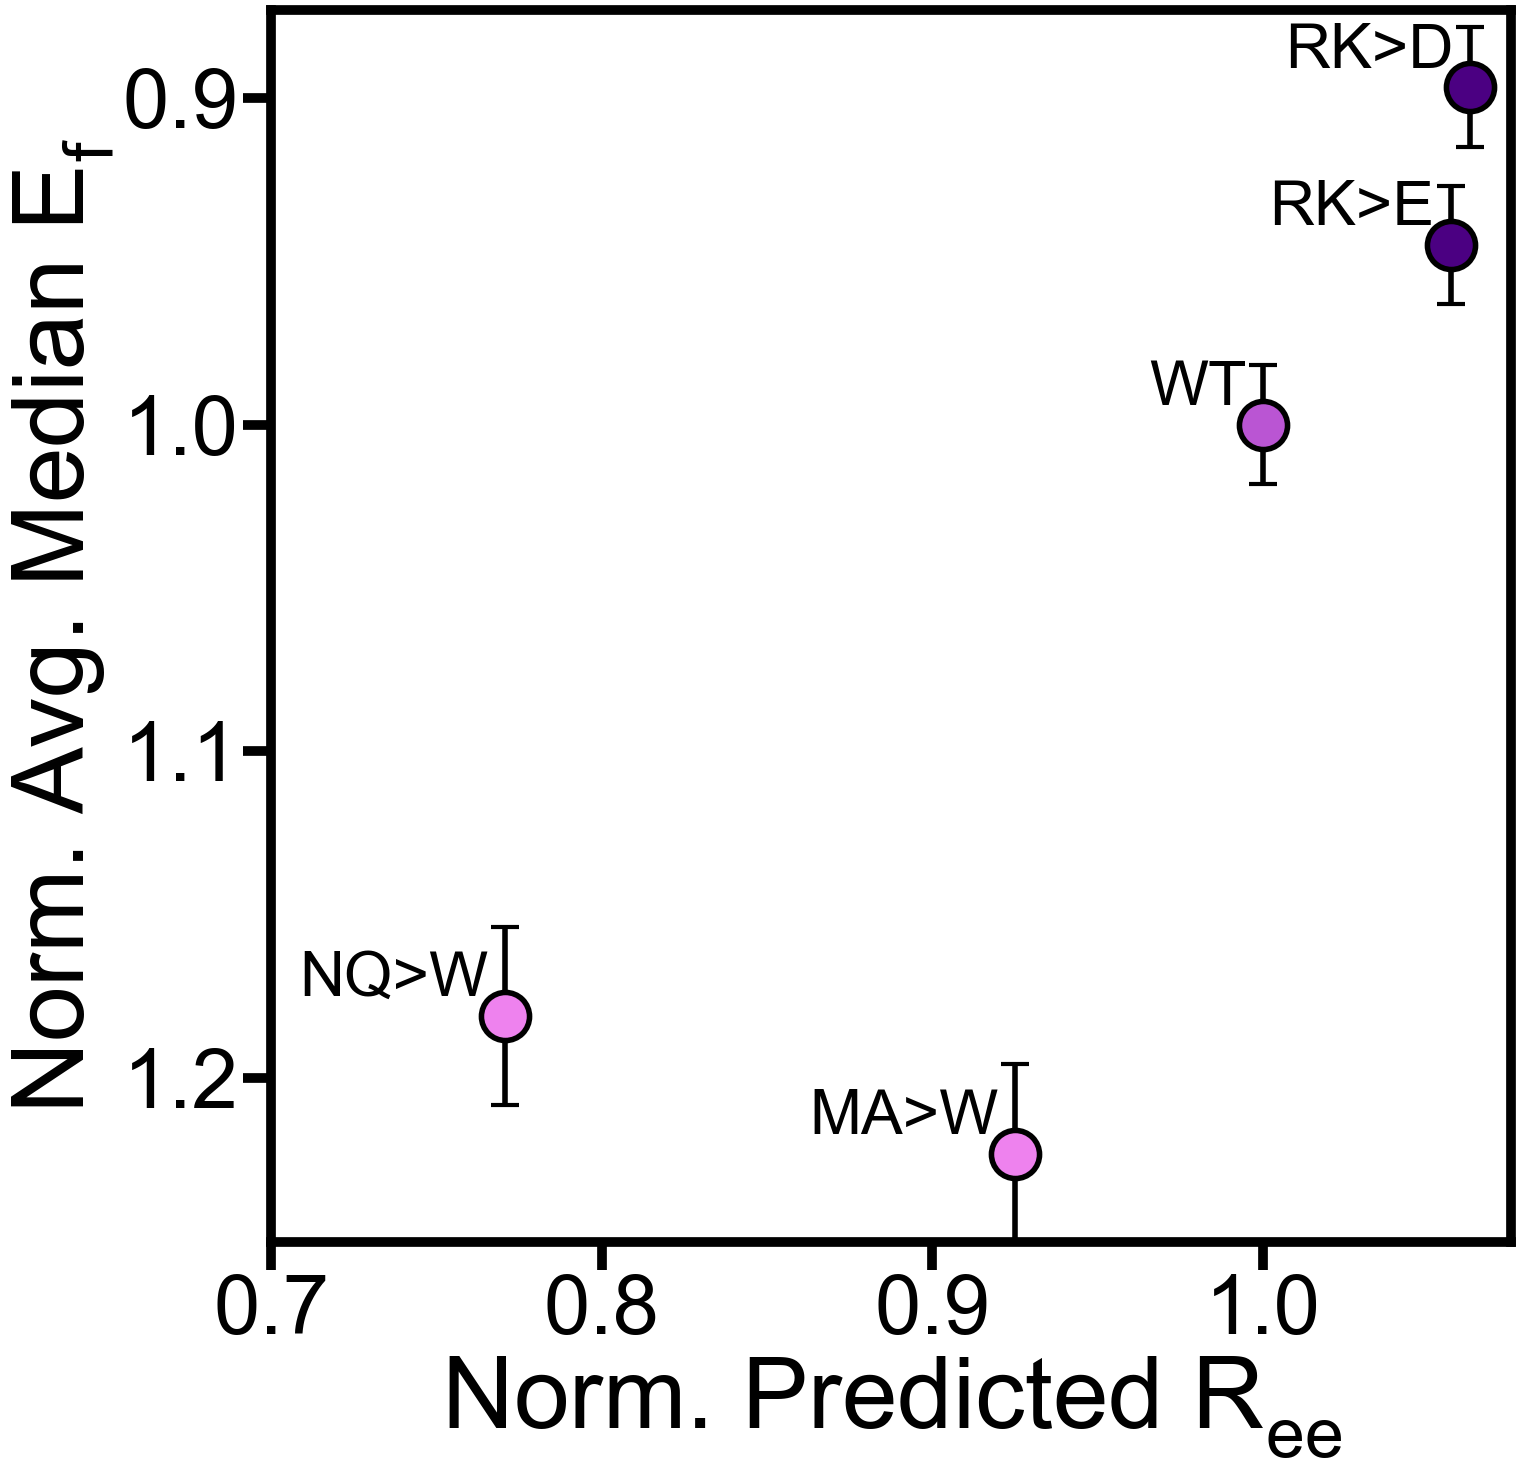

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Merge dataframes on 'mut name'
merged_df = pd.merge(sim_HIF, HIF_stats, on='mut name')

# Calculate Pearson's r
pearson_r, _ = pearsonr(merged_df['normalized_Ree'], merged_df['normalized_avg_median'])
print(f"Pearson's r: {pearson_r:.3f}")

# Color mapping based on mut name
color_mapping = {
    'NQ>W': 'violet',
    'MA>W': 'violet',
    'WT': 'mediumorchid',
    'RK>E': 'indigo',
    'RK>D': 'indigo'
}

# Plotting
plt.figure(figsize=(16, 16))

# Scatter plot with color mapping and black outline
for index, row in merged_df.iterrows():
    plt.scatter(row['normalized_Ree'], row['normalized_avg_median'],
                s=1200,  # Size of the marker
                color=color_mapping.get(row['mut name'], 'purple'),  # Use color mapping
                edgecolor='black',  # Black outline
                linewidth=4,  # Width of the edge
                alpha=1,
                zorder=3)

# Adding error bars
for index, row in merged_df.iterrows():
    plt.errorbar(row['normalized_Ree'], row['normalized_avg_median'],
                 yerr=row['propagated_error'],  # Add vertical error bars
                 fmt='o',  # Use circle markers
                 markersize=10,  # Size of the marker
                 color=color_mapping.get(row['mut name'], 'purple'),  # Use color mapping for markers
                 ecolor='black',  # Color of the error bars
                 elinewidth=4,  # Width of the error bars
                 capthick=3,
                 capsize=10,  # Length of the caps on the error bars
                 alpha=1)

# Adding text labels for mut name
for index, row in merged_df.iterrows():
    plt.text(row['normalized_Ree']-.005,  # X position
             row['normalized_avg_median']-.0025,  # Y position
             row['mut name'],
             color='Black',
             fontsize=45,
             ha='right',  # Horizontal alignment
             va='bottom')  # Vertical alignment

plt.xlabel('Norm. Predicted R$_{ee}$')
plt.ylabel('Norm. Avg. Median E$_{f}$')
plt.ylim([1.25, .873])  # Adjust these limits based on your data
plt.xlim([.7, 1.075])  # Adjust these limits based on your data
plt.show()


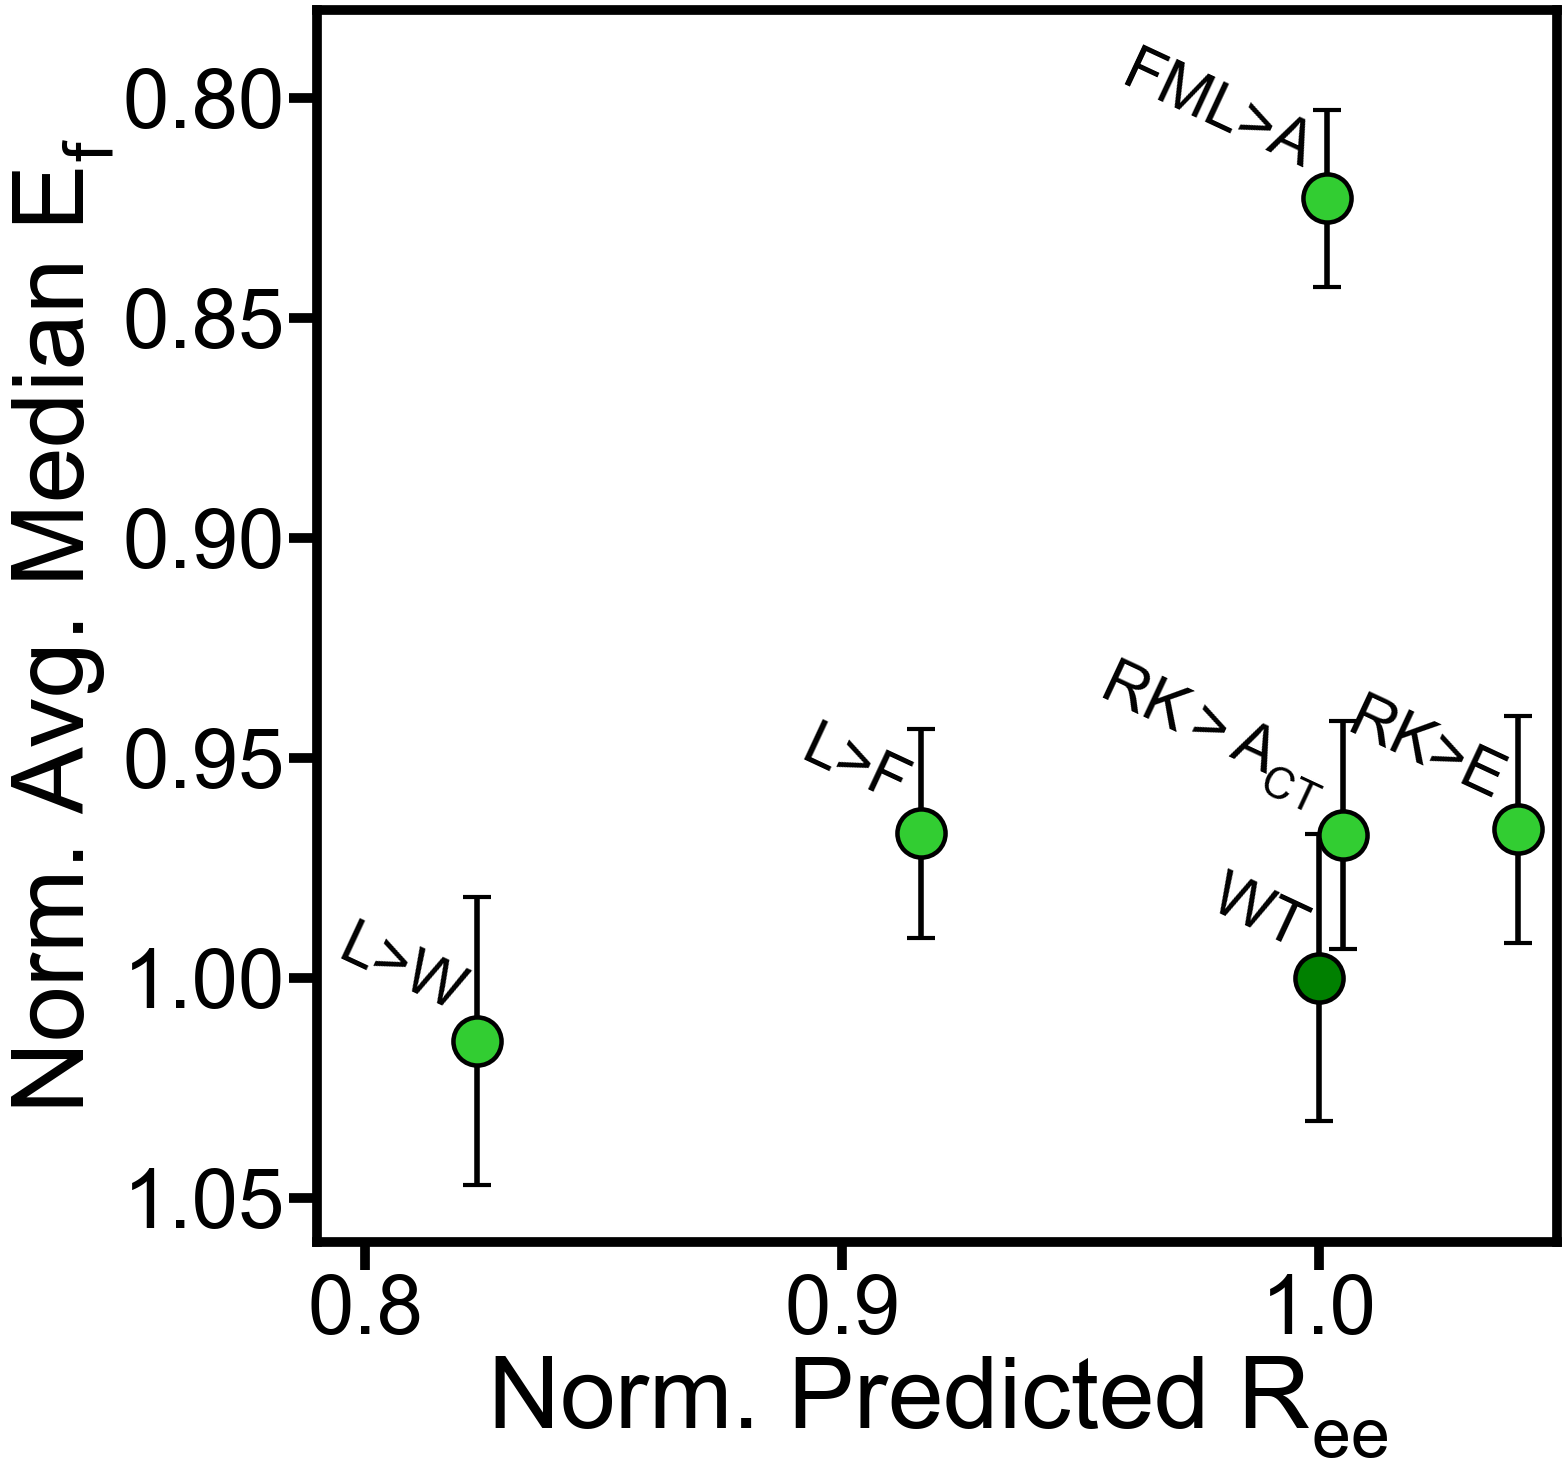

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming sim_CITED2 and CITED2_stats are predefined DataFrames
merged_df = pd.merge(sim_CITED2, CITED2_stats, on='mut name')

# Filter the DataFrame to only include the specified mutants
mut_names = ['FML>A', 'L>F', 'L>W', 'WT', 'RK>E', 'RK>Amut20to39']
filtered_df = merged_df[merged_df['mut name'].isin(mut_names)]

# Color mapping based on mut name
color_mapping = {
    'FML>A': 'LimeGreen',
    'L>F': 'LimeGreen',
    'L>W': 'LimeGreen',
    'WT': 'green',
    'RK>E': 'LimeGreen',
    'RK>Amut20to39': 'LimeGreen'  # Assuming a color for RK>Amut20to39
}

# Plotting
plt.figure(figsize=(16, 16))
for index, row in filtered_df.iterrows():
    color = color_mapping.get(row['mut name'], 'green')  # Default color if not found in mapping
    plt.scatter(row['normalized_Ree'], row['normalized_avg_median'], s=1200, color=color, alpha=1, 
                zorder=4, edgecolor='black',linewidth=3.25) # Width of the edge
            
    plt.errorbar(row['normalized_Ree'], row['normalized_avg_median'], 
                 yerr=row['propagated_error'],  # Add vertical error bars
                 fmt='o',  # Use circle markers
                 markersize=10,  # Size of the marker
                 color=color,  # Color of the marker
                 ecolor='black',  # Color of the error bars
                 elinewidth=4,  # Width of the error bars
                 capthick=3,
                 capsize=10,  # Length of the caps on the error bars
                 alpha=1)

# Replace specific labels in the loop where text annotations are added
label_replacements = {
    'ED>A0to20': 'ED$>A_{NT}$',
    'RK>Amut20to39': 'RK$>A_{CT}$'
}

for index, row in filtered_df.iterrows():
    # Replace the label if it is in the dictionary
    label = label_replacements.get(row['mut name'], row['mut name'])
    plt.text(row['normalized_Ree']- 0.001, row['normalized_avg_median'] - 0.004,
             label,
             rotation=-25,
             color='Black',
             ha='right',
             fontsize=45,
             zorder=4,
             va='bottom')

plt.xlabel('Norm. Predicted R$_{ee}$')
plt.ylabel('Norm. Avg. Median E$_{f}$')
plt.ylim([1.06, 0.78])
plt.xlim([0.79, 1.05])

plt.show()